In [1]:
# --- CELL 1: Cài đặt (Bản Final - Bỏ qua lỗi đỏ) ---

# 1. Gỡ cài đặt cũ để tránh rác
!pip uninstall -y trl transformers peft accelerate bitsandbytes protobuf

# 2. Cài đặt các thư viện cần thiết
# Lưu ý: Sẽ có chữ ERROR màu đỏ xuất hiện do xung đột với TensorFlow/GoogleCloud
!pip install -q -U bitsandbytes
!pip install -q -U triton
!pip install -q protobuf==3.20.3  # Giữ nguyên bản này để fix lỗi Tokenizer
!pip install -q transformers==4.46.1 # Dùng bản .1 để tránh cảnh báo 'yanked'
!pip install -q peft==0.11.1
!pip install -q accelerate==0.34.2
!pip install -q trl==0.8.6
!pip install -q datasets scipy openpyxl

# --- CELL: Cài đặt thư viện đánh giá ---
!pip install -q evaluate bert_score rouge_score absl-py
!pip install -q nltk

# Tải dữ liệu cần thiết cho METEOR
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
print("✅ Đã cài xong bộ công cụ đánh giá!")

print("✅ Cài đặt hoàn tất!")
print("⚠️ BẮT BUỘC: Vào menu 'Run' -> 'Restart & clear cell outputs' ngay bây giờ!")

Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: peft 0.17.1
Uninstalling peft-0.17.1:
  Successfully uninstalled peft-0.17.1
Found existing installation: accelerate 1.11.0
Uninstalling accelerate-1.11.0:
  Successfully uninstalled accelerate-1.11.0
Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 11.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.8.0+cu126 requires triton==3.4.0; platform_system == "Linux" and platform_machine == "x86_64", but you have triton 3.5.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


✅ Đã cài xong bộ công cụ đánh giá!
✅ Cài đặt hoàn tất!
⚠️ BẮT BUỘC: Vào menu 'Run' -> 'Restart & clear cell outputs' ngay bây giờ!


In [2]:
# --- CELL 2: Load Model 
import os
import torch
import pandas as pd
import gc

# --- FIX QUAN TRỌNG: ÉP ĐƯỜNG DẪN CUDA ---
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu:" + os.environ.get("LD_LIBRARY_PATH", "")
# ----------------------------------------

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# 1. DỌN DẸP BỘ NHỚ
gc.collect()
torch.cuda.empty_cache()

# Kiểm tra xem PyTorch có nhận GPU không
print(f" PyTorch version: {torch.__version__}")
print(f" CUDA version: {torch.version.cuda}")
if not torch.cuda.is_available():
    raise RuntimeError("❌ Lỗi nghiêm trọng: PyTorch không nhìn thấy GPU!")

# 2. CẤU HÌNH DATA
data_file_path = "/kaggle/input/stats-data/All_Datasets_utf8.csv" 
model_name = "Qwen/Qwen2.5-7B-Instruct"

try:
    df = pd.read_csv(data_file_path)
    full_dataset = Dataset.from_pandas(df)
    dataset = full_dataset.train_test_split(test_size=0.01)["train"]
    print(f"✅ Đã load {len(dataset)} dòng dữ liệu.")
except Exception as e:
    print(f"❌ Lỗi đọc file (kiểm tra lại path): {e}")


# 3. CẤU HÌNH QUANTIZATION
# Dùng nf4 và float16 (chuẩn nhất cho T4)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# 4. LOAD MODEL
print(" Đang tải Model Qwen2.5 (Fix lỗi bitsandbytes)...")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16
)

# Tắt cache
model.config.use_cache = False 

# 5. LOAD TOKENIZER
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print("THÀNH CÔNG! Model đã load vào GPU.")

 PyTorch version: 2.8.0+cu126
 CUDA version: 12.6
✅ Đã load 777 dòng dữ liệu.
 Đang tải Model Qwen2.5 (Fix lỗi bitsandbytes)...


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

2026-01-13 14:30:47.691263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768314647.925716      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768314647.997275      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768314648.569470      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768314648.569512      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768314648.569515      23 computation_placer.cc:177] computation placer alr

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

THÀNH CÔNG! Model đã load vào GPU.


In [3]:
# --- CELL 3: Train Model
from transformers import TrainingArguments
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import sys

# 1. Chuẩn bị model
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# 2. Cấu hình LoRA 
peft_config = LoraConfig(
    r=32,           
    lora_alpha=64,  
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

# 3. Hàm format dữ liệu (Giữ nguyên logic thông minh)
def formatting_prompts_func(examples):
    output_texts = []
    key_map = {k.lower().strip(): k for k in examples.keys()}
    inst_col  = key_map.get('instruction')
    latex_col = key_map.get('latex input')
    resp_col  = key_map.get('response')
    
    if not inst_col or not latex_col or not resp_col:
        return [] # Tránh lỗi nếu batch rỗng

    for inst, inp, resp in zip(examples[inst_col], examples[latex_col], examples[resp_col]):
        inst = str(inst) if inst is not None else ""
        inp  = str(inp)  if inp is not None else ""
        resp = str(resp) if resp is not None else ""
        user_content = f"{inst}\n\n{inp}".strip()
        text = f"<|im_start|>user\n{user_content}<|im_end|>\n<|im_start|>assistant\n{resp}<|im_end|>"
        output_texts.append(text)
    return output_texts

# 4. Training Arguments (Cập nhật Epoch và Checkpoint)
training_args = TrainingArguments(
    output_dir="/kaggle/working/results",
    per_device_train_batch_size=2,   # Batch size nhỏ để tiết kiệm VRAM
    gradient_accumulation_steps=8,   # Tích lũy gradient
    
    # --- CẤU HÌNH MỚI ---
    num_train_epochs=3,             
    learning_rate=2e-4,              
    
    # --- CẤU HÌNH CHECKPOINT ---
    save_strategy="steps",           
    save_steps=25,                   # Lưu sau mỗi 25 bước 
    save_total_limit=3,              # Giữ lại 3 checkpoint tốt nhất, xóa cái cũ đi cho đỡ tốn bộ nhớ
    logging_steps=5,                 # In log 
    
    fp16=True,       
    bf16=False,
    optim="paged_adamw_8bit",
    report_to="none",
    ddp_find_unused_parameters=False
)

# 5. Khởi tạo Trainer
print(" Đang khởi tạo Trainer với cấu hình: 5 Epochs, Rank 32...")
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    formatting_func=formatting_prompts_func,
    max_seq_length=1024,
    args=training_args,
)

print("Bắt đầu Train...")
trainer.train()

# --- LƯU NGAY LẬP TỨC ---
try:
    # Đặt tên repo 
    repo_name = "vatine/Qwen2.5-7B-Math-Final-E5" 
    
    trainer.model.push_to_hub(repo_name)
    tokenizer.push_to_hub(repo_name)
    print("ĐÃ LƯU AN TOÀN TRÊN HUGGINGFACE!")
except Exception as e:
    print(f" Lỗi đẩy lên Hub: {e}")
    # Vẫn lưu local để Kaggle đóng gói
    trainer.model.save_pretrained("local_model_final")
    tokenizer.save_pretrained("local_model_final")

 Đang khởi tạo Trainer với cấu hình: 5 Epochs, Rank 32...


Map:   0%|          | 0/777 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Bắt đầu Train...


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
5,1.103300
10,0.719500
15,0.541800
20,0.421100
25,0.384500
30,0.344800
35,0.319200
40,0.271400
45,0.307700
50,0.302400


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/

 Lỗi đẩy lên Hub: 401 Client Error: Unauthorized for url: https://huggingface.co/api/repos/create (Request ID: Root=1-69666b33-616c0f3e186a2126333c304b;f3c7dc49-db14-4f98-899e-9f3914617589)

Invalid username or password.


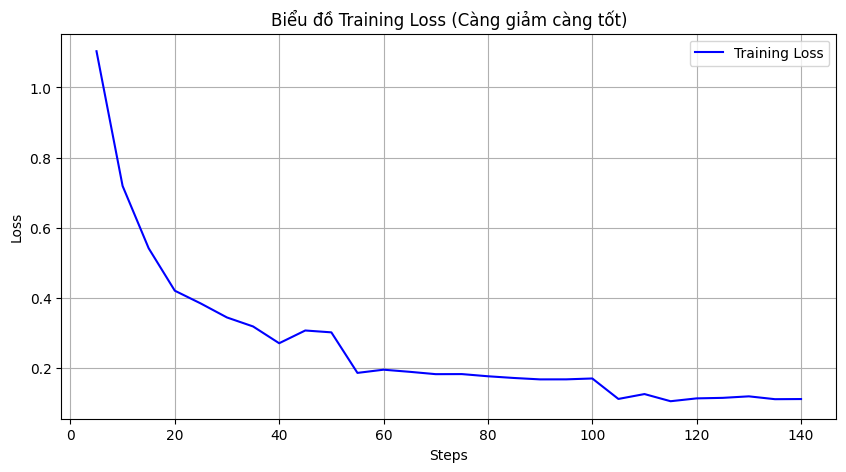

 Loss bắt đầu: 1.1033
 Loss kết thúc: 0.1124
✅ Kết luận: Model ĐANG HỌC (Loss giảm).


In [4]:
# --- CELL 4: Vẽ biểu đồ Loss ---
import matplotlib.pyplot as plt
import pandas as pd

# 1. Lấy lịch sử training từ Trainer
history = trainer.state.log_history

# 2. Lọc dữ liệu loss
train_loss = []
steps = []

for log in history:
    if 'loss' in log:
        train_loss.append(log['loss'])
        steps.append(log['step'])

# 3. Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label='Training Loss', color='blue')
plt.title('Biểu đồ Training Loss (Càng giảm càng tốt)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Đánh giá nhanh
if len(train_loss) > 0:
    print(f" Loss bắt đầu: {train_loss[0]:.4f}")
    print(f" Loss kết thúc: {train_loss[-1]:.4f}")
    if train_loss[-1] < train_loss[0]:
        print("✅ Kết luận: Model ĐANG HỌC (Loss giảm).")
    else:
        print("⚠️ Kết luận: Model chưa học tốt (Loss không giảm), cần tăng Learning Rate hoặc kiểm tra lại Data.")

In [5]:
# --- CELL 5: Đánh giá Mô hình (BLEU, ROUGE, METEOR, BERTScore) ---
import torch
import evaluate
import pandas as pd
import gc
from tqdm import tqdm

# 1. CHUẨN BỊ DỮ LIỆU TEST
# Lấy 20 mẫu từ tập test để đánh giá (Lấy nhiều quá sẽ lâu)
# Nếu bạn chưa tách test, code này sẽ lấy 5 dòng cuối
try:
    test_data = dataset.select(range(len(dataset)-5, len(dataset)))
except:
    test_data = dataset.select(range(min(5, len(dataset))))

print(f" Đang đánh giá trên {len(test_data)} mẫu dữ liệu...")

# 2. SINH CÂU TRẢ LỜI (PREDICTION)
predictions = []
references = []

print(" Đang sinh câu trả lời từ model...")
for item in tqdm(test_data):
    # Lấy Input
    key_map = {k.lower().strip(): k for k in item.keys()}
    inst = str(item[key_map.get('instruction', 'instruction')])
    inp  = str(item[key_map.get('latex input', 'latex input')])
    
    # Lấy Đáp án gốc (Reference)
    ground_truth = str(item[key_map.get('response', 'response')])
    references.append(ground_truth)
    
    # Tạo Prompt
    user_content = f"{inst}\n\n{inp}".strip()
    messages = [{"role": "user", "content": user_content}]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    # Generate
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=512,
            temperature=0.1, 
            top_p=0.9
        )
    
    # Decode
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    predictions.append(response)

# 3. GIẢI PHÓNG VRAM 
print(" Đang dọn dẹp VRAM để chấm điểm...")
del model
del tokenizer
gc.collect()
torch.cuda.empty_cache()

# 4. TÍNH TOÁN CÁC METRICS
print(" Đang tính toán điểm số (Metrics)...")

# Load metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

# --- Tính BLEU ---
results_bleu = bleu.compute(predictions=predictions, references=references)

# --- Tính ROUGE ---
results_rouge = rouge.compute(predictions=predictions, references=references)

# --- Tính METEOR ---
results_meteor = meteor.compute(predictions=predictions, references=references)

# --- Tính BERTScore (Dùng model đa ngôn ngữ) ---
# lang="vi" sẽ tự động tải model bert-base-multilingual-cased
results_bert = bertscore.compute(predictions=predictions, references=references, lang="vi")

# 5. HIỂN THỊ KẾT QUẢ
print("\n" + "="*40)
print(" KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH (FINAL REPORT)")
print("="*40)

print(f"🔹 BLEU Score:  {results_bleu['bleu']:.4f}")
print(f"🔹 ROUGE-1:     {results_rouge['rouge1']:.4f} (Độ trùng khớp từ đơn)")
print(f"🔹 ROUGE-L:     {results_rouge['rougeL']:.4f} (Độ trùng khớp cấu trúc câu)")
print(f"🔹 METEOR:      {results_meteor['meteor']:.4f} (Độ tương đồng ngữ nghĩa cơ bản)")
print(f"🔹 BERTScore F1:{sum(results_bert['f1']) / len(results_bert['f1']):.4f} (Độ tương đồng ngữ nghĩa sâu)")

print("\n📝NHẬN XÉT SƠ BỘ:")
f1_bert = sum(results_bert['f1']) / len(results_bert['f1'])
if f1_bert > 0.85:
    print("Model xuất sắc! Câu trả lời rất sát nghĩa với đáp án gốc.")
elif f1_bert > 0.75:
    print("Model tốt. Hiểu ý nhưng cách diễn đạt có thể khác đáp án một chút.")
else:
    print("Model cần cải thiện. Câu trả lời còn lệch nhiều so với đáp án.")
print("="*40)

 Đang đánh giá trên 5 mẫu dữ liệu...
 Đang sinh câu trả lời từ model...


  0%|          | 0/5 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 5/5 [15:22<00:00, 184.55s/it]


 Đang dọn dẹp VRAM để chấm điểm...
 Đang tính toán điểm số (Metrics)...


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


 KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH (FINAL REPORT)
🔹 BLEU Score:  0.4393
🔹 ROUGE-1:     0.7505 (Độ trùng khớp từ đơn)
🔹 ROUGE-L:     0.6792 (Độ trùng khớp cấu trúc câu)
🔹 METEOR:      0.7230 (Độ tương đồng ngữ nghĩa cơ bản)
🔹 BERTScore F1:0.8849 (Độ tương đồng ngữ nghĩa sâu)

📝NHẬN XÉT SƠ BỘ:
Model xuất sắc! Câu trả lời rất sát nghĩa với đáp án gốc.
